In [19]:
# Required libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras import layers, models
import joblib

In [21]:
zip_path = "C:\\Users\\megha\\Downloads\\archive.zip"
extract_folder = 'ecg5000_extracted'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

train_path = os.path.join(extract_folder, 'ECG5000_TRAIN.txt')
test_path = os.path.join(extract_folder, 'ECG5000_TEST.txt')


df = pd.concat([train_df, test_df], ignore_index=True)
labels = df.iloc[:, 0]
features = df.iloc[:, 1:]

In [22]:
y = (labels == 1).astype(int)  # Normal = 1, Others = 0
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_normal = X_train[y_train == 1]  # Use only normal for training



In [23]:
#Define Autoencoder

input_dim = X_train_normal.shape[1]
autoencoder = models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(input_dim, activation='linear')
])
autoencoder.compile(optimizer='adam', loss='mse')

In [24]:
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)



Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7454 - val_loss: 0.3188
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2243 - val_loss: 0.1741
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1378 - val_loss: 0.1497
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1159 - val_loss: 0.1341
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1054 - val_loss: 0.1235
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0870 - val_loss: 0.1173
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0849 - val_loss: 0.1121
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0761 - val_loss: 0.1101
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0738 - val_loss: 0.1077
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0712 - val_loss: 0.1049
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0676 - val_loss: 0.1038
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0683 - val_lo

In [25]:
reconstructions = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.square(X_test - reconstructions), axis=1)

train_recon = autoencoder.predict(X_train_normal)
train_mse = np.mean((train_recon - X_train_normal) ** 2, axis=1)
threshold = np.percentile(train_mse, 95)

y_pred = (reconstruction_error <= threshold).astype(int)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


In [26]:
print("✅ Threshold for anomaly detection:", threshold)
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")

✅ Threshold for anomaly detection: 0.09908120147990897

Confusion Matrix:
 [[413   1]
 [ 49 537]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       414
           1       1.00      0.92      0.96       586

    accuracy                           0.95      1000
   macro avg       0.95      0.96      0.95      1000
weighted avg       0.96      0.95      0.95      1000

Accuracy: 95.00%


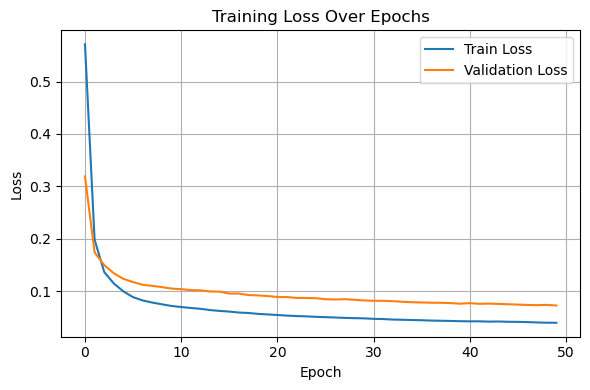

In [27]:
# Plots
# Loss plot
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

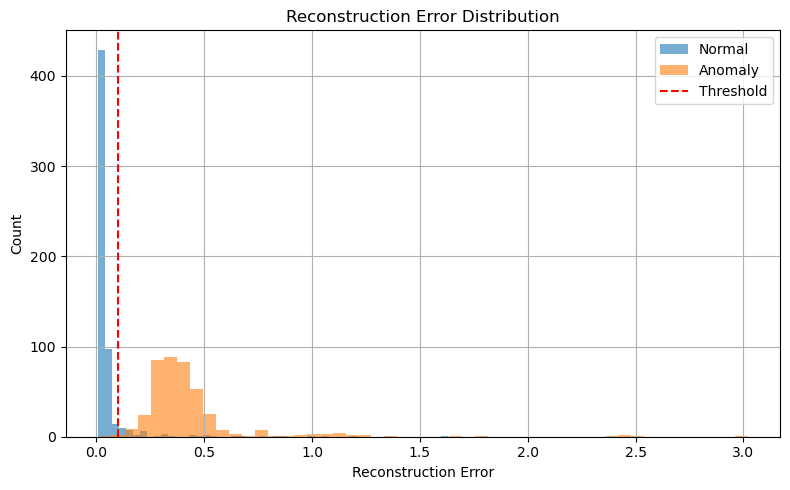

In [28]:
# Histogram of reconstruction errors
plt.figure(figsize=(8,5))
plt.hist(reconstruction_error[y_test == 1], bins=50, alpha=0.6, label='Normal')
plt.hist(reconstruction_error[y_test == 0], bins=50, alpha=0.6, label='Anomaly')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

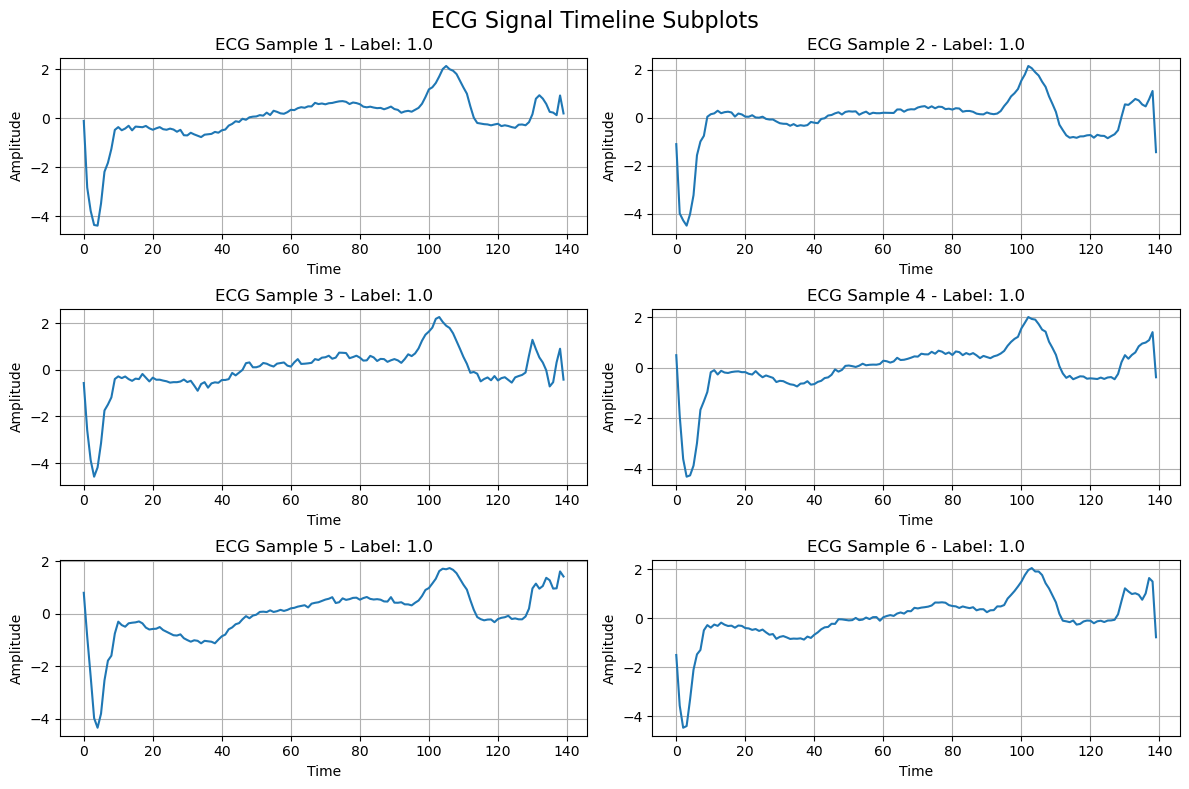

In [29]:
#  ECG Timeline Subplots

plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(3, 2, i + 1)
    plt.plot(features.iloc[i].values)
    plt.title(f"ECG Sample {i+1} - Label: {labels.iloc[i]}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.tight_layout()
plt.suptitle("ECG Signal Timeline Subplots", fontsize=16)
plt.subplots_adjust(top=0.92)
plt.show()